In [1]:
from pylab import *
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.morphology import disk, dilation, erosion
from skimage.exposure import equalize_adapthist

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from scipy.stats import moment
import cv2

## Wstępne przetworzenie obrazu

In [2]:
def image_preprocessing(image):
    image = img_as_float(plt.imread(image))

    mask = rgb2gray(image)
    mask[mask > 0.15] = 1
    mask[mask <= 0.15] = 0
    mask = -mask
    mask = erosion(mask, disk(1))
    mask = dilation(mask, disk(5))
    mask = erosion(mask, disk(2))

    image = image[:,:,1]
    image = equalize_adapthist(image, clip_limit=0.02)
    
    image[mask == 0] = 0
    
    return image

## Wczytanie danych

In [3]:
folder = 'pictures/'
images = ['im0001', 'im0002', 'im0003', 'im0004', 'im0005', 'im0044', 'im0077', 'im0081',
          'im0082', 'im0139', 'im0162', 'im0163', 'im0235', 'im0236', 'im0239', 'im0240',
          'im0255', 'im0291', 'im0319', 'im0324']
in_img = '.ppm'
out_img = '.ah.ppm'

In [4]:
data_list = []
target_list = []

learn_images = images[:3]

for img in images:
    data_list += [image_preprocessing(folder + img + in_img)]
    target_list += [img_as_float(plt.imread(folder + img + out_img))]

## Ekstrakcja cech z obrazu

In [5]:
## funkcja zwracająca informacje o dzjęciach wykorzystanych do nauki
def features_labe_create(data_list, target_list):
    
    variance = []
    central_moment_3 = []
    central_moment_4 = []
    hu_moment = []
    target = []
    
    n = 5
    
    for image_data in data_list:
        x, y = image_data.shape
        for i in range(x // n):
            for j in range(y // n):
                img_data = image_data[n*i : n*(i+1), n*j : n*(j+1)].flatten()
                variance += [moment(img_data, moment = 2)]
                central_moment_3 += [moment(img_data, moment = 3)]
                central_moment_4 += [moment(img_data, moment = 4)]
                hu_moment += [cv2.HuMoments(cv2.moments(img_data))]
            
    for image_target in target_list:
        x, y = image_target.shape
        for i in range(x // n):
            for j in range(y // n):
                img_target = image_target[n*i : n*(i+1), n*j : n*(j+1)]
                target += [img_target[2,2]]
            
    return variance, central_moment_3, central_moment_4, target


## funkcja zwracająca informacje o zdjęciu, z którego chcemy wyodrębnić naczynia
def features_create(image_data):
    
    variance = []
    central_moment_3 = []
    central_moment_4 = []
    hu_moment = []
    
    n = 5
    
    x, y = image_data.shape
    for i in range(x // n):
        for j in range(y // n):
            img_data = image_data[n*i : n*(i+1), n*j : n*(j+1)].flatten()
            variance += [moment(img_data, moment = 2)]
            central_moment_3 += [moment(img_data, moment = 3)]
            central_moment_4 += [moment(img_data, moment = 4)]
            hu_moment += [cv2.HuMoments(cv2.moments(img_data))]
            
    return list(zip(variance, central_moment_3, central_moment_4))

## Klasyfikator

In [6]:
variance, central_moment_3, central_moment_4, target = features_labe_create(data_list, target_list)
features = list(zip(variance, central_moment_3, central_moment_4))
label = target

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3)

model = KNeighborsClassifier(n_neighbors=15)
model.fit(X_train, y_train)

print("Zdolność predykcyjna:",metrics.accuracy_score(y_test, model.predict(X_test)))

Zdolność predykcyjna: 0.9392955529319166


## Segmentacja obrazu

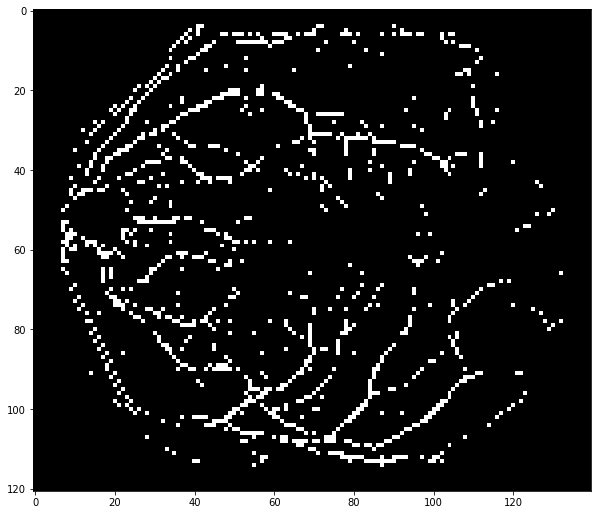

In [7]:
my_picture = image_preprocessing("pictures/im0077.ppm")
x, y = my_picture.shape
pct = features_create(my_picture)

predicted = model.predict(pct)
predicted = np.array_split(predicted, x//5)

plt.figure(figsize=(10, 10))
plt.imshow(predicted, cmap=plt.cm.gray)